## Imports

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import spacy
from datetime import datetime
nlp = spacy.load("en_core_web_sm")
import networkx as nx

# Data Loading

In [13]:
def string_to_date(str_date):
    if len(str(str_date)) == "":
        return None
    for fmt in ('%d %B %Y', '%d %b %Y', '%B %Y', "%b %Y", "%Y"):
        try:
            return datetime.strptime(str(str_date), fmt)
        except ValueError:
            pass
    raise ValueError(f'no valid date format found for {str_date}')

In [14]:
letters = pd.read_pickle("letters.pickle")
original_dates_corrected = pd.read_csv("original_dates.csv", sep=";")

letters = pd.merge(letters, original_dates_corrected, left_index=True, right_on="index").dropna()
letters.original_date_corrected = letters.original_date_corrected.apply(string_to_date)
destinataire = pd.read_csv("destinataire.csv", sep=";", names=["index", "receiver", "royal"])
destinataire["royal"] = destinataire.royal.apply(lambda x : type(x) is str)
letters = pd.merge(letters, destinataire, left_on="index", right_on = "index")
letters = letters.query("category != 'Mint' and receiver != 'Thomas Lord Arch-Bishop of Canterbury/William Lord Bishop of Worcester'")
letters.letter_content = letters.letter_content.apply(lambda x : " ".join(x.split()).lower())

# Visualisation of the correspondence

In [15]:
G = nx.Graph()
nodes = set()
edges = dict()
for index, row in letters.iterrows():
    nodes.add(row["author"])
    nodes.add(row["receiver"])
    if row["author"]+";"+row["receiver"] in edges.keys() or  row["receiver"]+";"+row["author"] in edges.keys():
        try:
            edges[row["author"]+";"+row["receiver"]] += 0.07
        except:
            edges[row["receiver"]+";"+row["author"]] += 0.07
    else:
        edges[row["author"]+";"+row["receiver"]] = 0.07
e = []
for k,v in edges.items():
    k1, k2 = k.split(";")
    e.append([k1,k2,v])
G.add_nodes_from(nodes)        
G.add_weighted_edges_from(e)
w = []
for a in list(G.edges(data=True)):
    w.append(a[-1]["weight"])

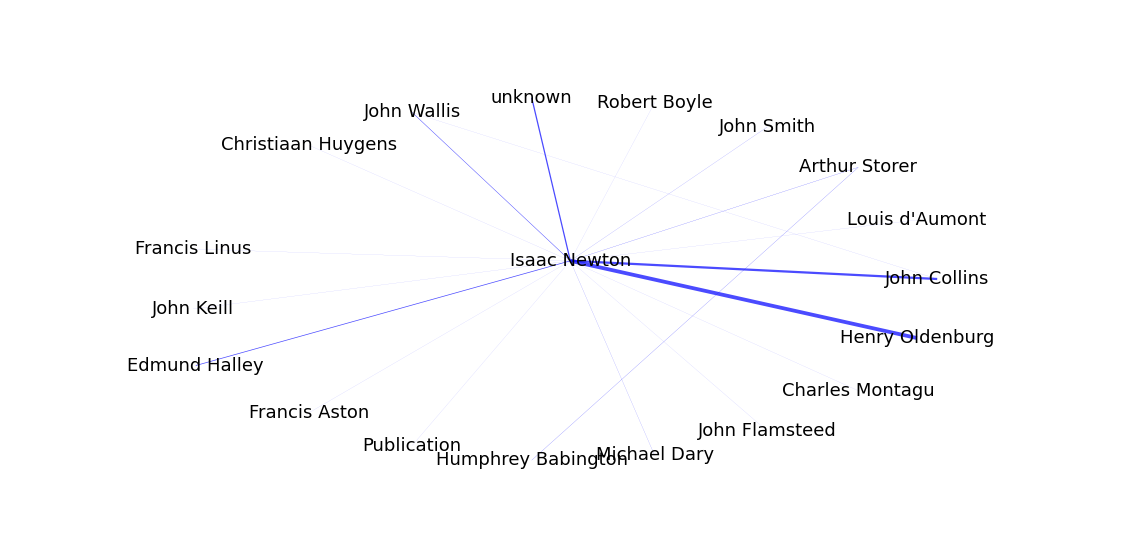

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
pos = nx.layout.circular_layout(G)

pos["Isaac Newton"][0]+=0.9
pos["Isaac Newton"][1]=0.1
pos["Edmund Halley"][0]-=0.1
edges = nx.draw_networkx_edges(
    G,
    pos,
    arrowstyle="->",
    arrowsize=10,
    edge_cmap=plt.cm.Blues,
    width=w,
    edge_color= "b",
    alpha=0.7
)
labels = nx.draw_networkx_labels(G, pos, font_size=18)

ax.set_axis_off()
x_values, y_values = zip(*pos.values())
x_max = max(x_values)
x_min = min(x_values)
x_margin = (x_max - x_min) * 0.25
plt.xlim(x_min - x_margin, x_max + x_margin)
y_max = max(y_values)
y_min = min(y_values)
y_margin = (y_max - y_min) * 0.25
plt.ylim(y_min - y_margin, y_max + y_margin)
plt.show()

## Data exploration

### Counting 

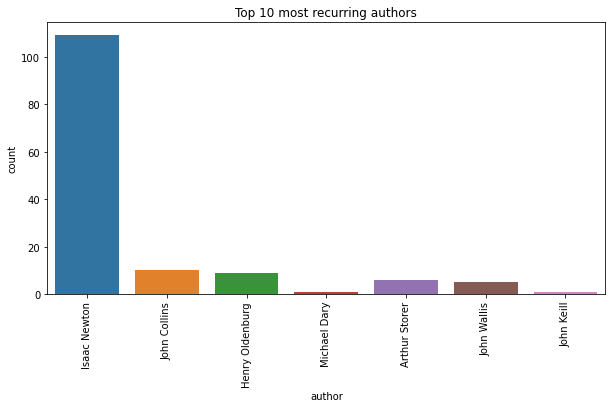

In [21]:
top_10_authors = letters.author.value_counts().index.to_list()[:20]
fig, axes = plt.subplots(figsize = (10, 5))
sns.countplot(data = letters[letters["author"].isin(top_10_authors)], x="author")
plt.xticks(rotation="vertical")
plt.title("Top 10 most recurring authors")
plt.show()

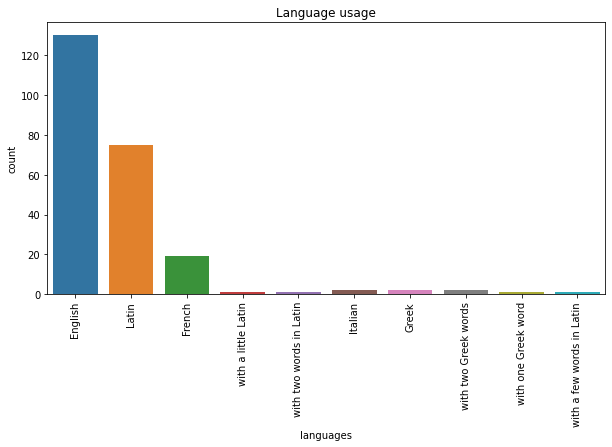

In [22]:
fig, axes = plt.subplots(figsize = (10, 5))
sns.countplot(data = letters.explode("languages"), x = "languages")
plt.xticks(rotation="vertical")
plt.title("Language usage")
plt.show()

### Distribution of letters over time

<AxesSubplot:title={'center':'Total number of letters per year'}, xlabel='original_date_corrected', ylabel='Count'>

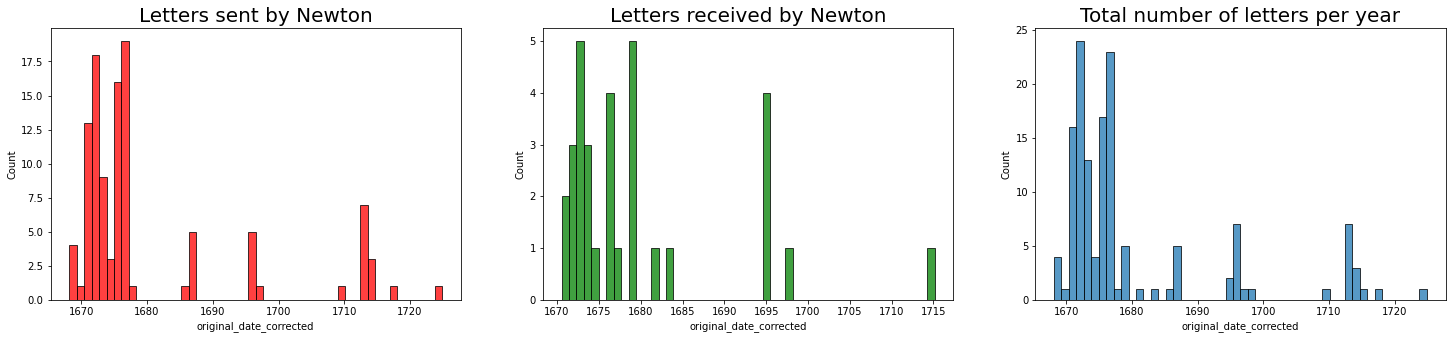

In [23]:
fig, axes = plt.subplots(1,3, figsize = (25, 5))

axes[0].set_title("Letters sent by Newton", fontsize=20)
sns.histplot(data = letters.query("author == 'Isaac Newton'"), x = "original_date_corrected", bins=50, ax=axes[0], color="red")
axes[1].set_title("Letters received by Newton", fontsize=20)
sns.histplot(data = letters.query("author != 'Isaac Newton'"), x = "original_date_corrected", bins=50, ax=axes[1], color="green")
axes[2].set_title("Total number of letters per year", fontsize=20)
sns.histplot(data = letters, x = "original_date_corrected", bins=50, ax=axes[2])

### Content analysis

Making a Spacy object with the texts of all letters

Ne pas run, ça prend trop de temps pour rien.

Counting the most reccuring words in these letters and printing the top 20 ones

```python
nlp.max_length = 1_100_000
doc = nlp(" ".join(letters.letter_content.values))
from collections import Counter

#Without stopwords and punctuation
words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common()

print(common_words[:60])
```

## Finding occurences of religious vocabulary

In [26]:
religious_voc = []
with open("newton_religious_vocabulary.txt", "r") as file:
    religious_voc = file.read().replace(", ", ",").split(",")

def contains_religious_voc(letter_content):
    words = []
    for rv in religious_voc:
        if rv in letter_content.split(" "):
            words.append(rv)
    return words

In [27]:
letters["religious_vocabulary"] = letters.letter_content.apply(contains_religious_voc)

In [28]:
count = 0
d = {}
for list_ in letters.religious_vocabulary:
    count += len(list_)
    for rv in list_:
        if rv in d.keys():
            d[rv] += 1
        else:
            d[rv] = 1
d   

{'trinity': 14,
 'history': 2,
 'god': 12,
 'roman': 4,
 'pope': 1,
 'adam': 8,
 'eve': 8,
 'law': 3,
 'church': 1,
 'philosophy': 5,
 'primitive': 1,
 'religion': 1}